In [1]:
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astropy.table import Table

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

from sst1mpipe.performance import get_mc_info, get_weights

from sst1mpipe.io import (
    load_dl1_sst1m,
    load_config
)

from sst1mpipe.analysis import plot_mc_data

from sst1mpipe.utils import (
    get_survived_ped_fraction,
    get_tel_string,
    get_moon_params
)

from pyirf.spectral import (
    DAMPE_P_He_SPECTRUM
)

import tables
from ctapipe.io import read_table


In [2]:
import matplotlib as mpl
font = {'size'   : 18,
       'family': 'DejaVu Sans'}

mpl.rc('font', **font)
plt.rc('legend',fontsize=15)

In [3]:
def load_dl1_files(files, config=None, tel=None):
    i = 0
    
    for input_file in files:

        try:
            df = load_dl1_sst1m(input_file, tel=tel, config=config, table='pandas')
        except:
            print("No such node", input_file)
            continue
        if i == 0:
            dl1_data = df
        else:
            try:
                dl1_data = pd.concat([dl1_data, df])
            except:
                print("Broken file", input_file)
        i += 1
    return dl1_data

In [4]:
def make_file_list(dates, data_path, wobble=''):
    
    files_selected = []
    
    for date in dates:
        files = glob.glob(data_path + "*" + str(date) + '*' + wobble + '*dl1.h5')

        files_selected = files_selected + files
    
    files_selected = np.sort(files_selected)
    return files_selected

# Input path, cfg files

In [5]:
data_path = '/mnt/nfs22_auger/jurysek/sst1m_data/cs1/dl1_sst1mpipe_1ES1959/'
log_dir = data_path+'/output/'

outfile_pedestals = '/home/jurysek/sst1mpipe_workdir/low_survived_pedestals_1ES1959.txt'
PED_FRACTION_CUT = 4*10**-4
save_good_file_list = False

config_file = '/home/jurysek/sst1mpipe_workdir/cfg/sst1mpipe_data_config_analysis_1ES1959.json'

tel = '1'
wobble = ''

# Observation dates

In [6]:
dates = np.array(
    [20230917]
)

In [7]:
files_selected = make_file_list(dates, data_path, wobble=wobble)

# Events after selection cuts

In [8]:
config = load_config(config_file)

In [9]:
config['event_selection']

{'camera_frame_hillas_intensity': [50, 1000000],
 'camera_frame_hillas_width': [0.002, 100],
 'camera_frame_hillas_length': [0, 100],
 'leakage_intensity_width_2': [0, 0.7]}

In [10]:
tel_data = get_tel_string(tel, mc=False)
tel_mc = get_tel_string(tel, mc=True)

In [11]:
dl1_data = load_dl1_files(files_selected, config=config, tel=tel_data)

# Average event rates and survived pedestals

In [12]:
logs = glob.glob(log_dir + "*.out")

In [13]:
zenith_angles, times, ped_fractions, wobble, runs, filenames = get_survived_ped_fraction(files_selected, logs=logs, tel=tel_data)

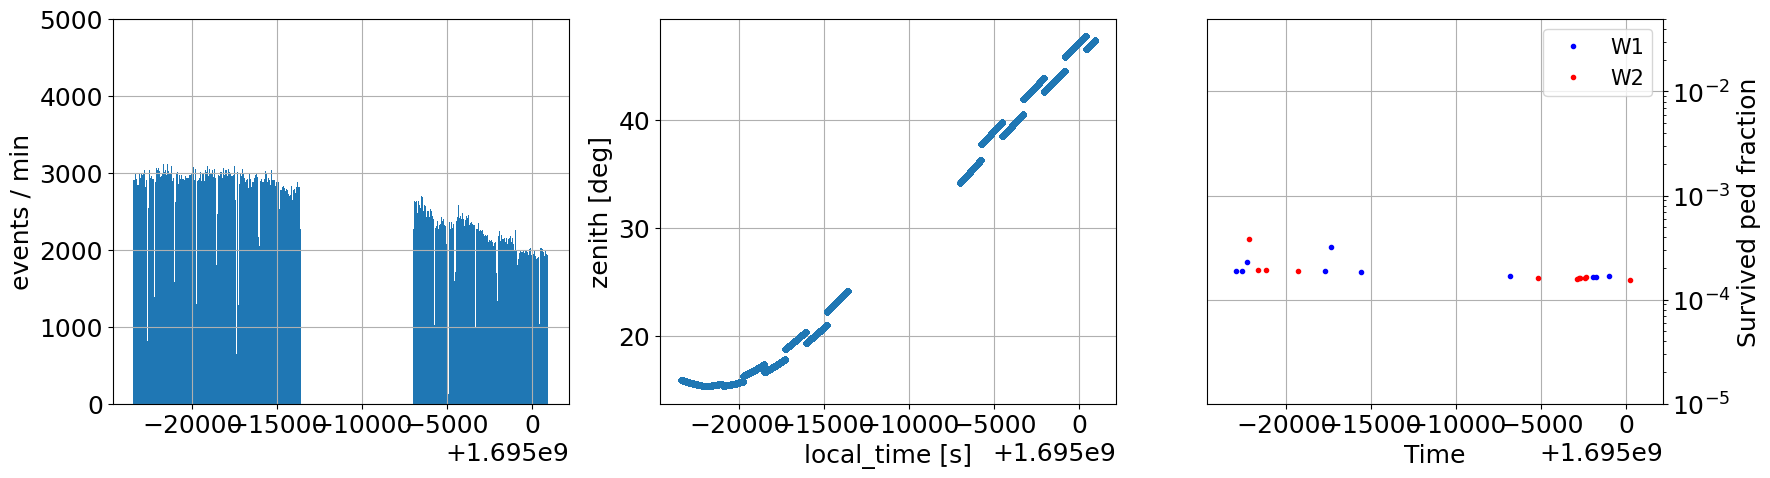

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
h1 = ax[0].hist(dl1_data.local_time, bins=int((max(dl1_data.local_time)-min(dl1_data.local_time))/60))
ax[0].set_ylabel('events / min')
ax[0].set_ylim([0, 5000])
ax[0].grid()

ax[1].plot(dl1_data['local_time'], 90-dl1_data['true_alt_tel'], '.')
ax[1].set_xlabel('local_time [s]')
ax[1].set_ylabel('zenith [deg]')
ax[1].grid()

ax[2].plot(times[wobble == "W1"], ped_fractions[wobble == "W1"], 'b.', label='W1')
ax[2].plot(times[wobble == "W2"], ped_fractions[wobble == "W2"], 'r.', label='W2')
ax[2].set_yscale('log')
ax[2].grid()
ax[2].legend()
ax[2].set_ylim([0.00001, 0.05])
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Survived ped fraction')
ax[2].yaxis.set_label_position("right")
ax[2].yaxis.tick_right()

# Moon

In [15]:
time, moon_altaz, moon_separation, moon_phase_angle = get_moon_params(dl1_data, config=config, tel=tel_data, thinning=100)

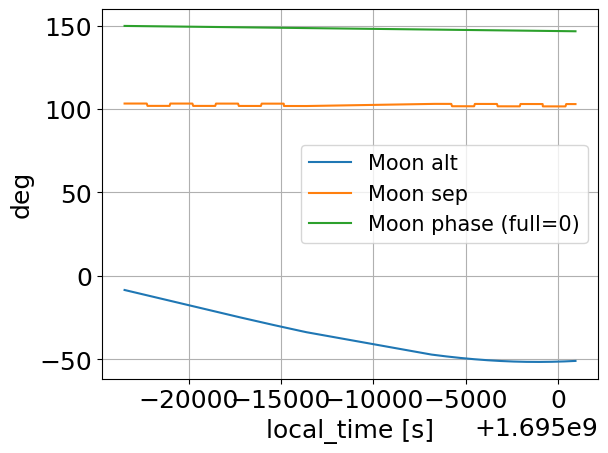

In [28]:
plt.plot(time.unix, moon_altaz.alt.to_value(u.deg), label='Moon alt')
plt.plot(time.unix, moon_separation.to_value(u.deg), label='Moon sep')
plt.plot(time.unix, moon_phase_angle.to_value(u.deg), label='Moon phase (full=0)')
plt.grid()
plt.ylabel('deg')
plt.xlabel('local_time [s]')
plt.legend()

### elapsed time: sum of time differences, excluding large ones

In [17]:
time_diff = dl1_data['local_time'].diff()
OBS_TIME = np.sum(time_diff[time_diff < 10. * u.s]) * u.s
print('Integration time (after cleaning and cuts):', OBS_TIME.to(u.hour))

Integration time (after cleaning and cuts): 4.77012568016847 h


## Store list of files with low survived pedestal fraction

In [18]:
if save_good_file_list:
    
    fraction_mask = ped_fractions < PED_FRACTION_CUT

    with open(outfile_pedestals, 'a') as the_file:
        for file in np.array(filenames)[fraction_mask]:
            print(file)
            the_file.write(file+'\n')

# MC-data comparison

In [19]:
zenith_mc = 20
zenith_range_data = [15, 25]

In [20]:
zenith_mask = (dl1_data.true_alt_tel > 90.-zenith_range_data[1]) & (dl1_data.true_alt_tel <= 90.-zenith_range_data[0])

In [21]:
input_file = '/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/protons_diffuse/zenith_'+str(zenith_mc)+'deg_psf_vaod0.2/proton_400_500E3GeV_'+str(zenith_mc)+'_'+str(zenith_mc)+'deg_training_dl1.h5'
proton_diffuse = load_dl1_sst1m(input_file, tel=tel_mc, config=config)

### Re-weighting on the real spectrum (DAMPE p+He)

In [22]:
simulated_event_info = get_mc_info(input_file)
proton_diffuse = get_weights(proton_diffuse, mc_info=simulated_event_info, obs_time=OBS_TIME, target_spectrum=DAMPE_P_He_SPECTRUM)

THE TOTAL NUMBER OF SIMULATED EVENTS WILL BE RECALCULATED FOR SPECTRAL REWEIGHTING.


In [23]:
scale = len(dl1_data[zenith_mask]['camera_frame_hillas_intensity']) / sum(proton_diffuse["weight"])
print('MC scale to fit the data (len data/sum proton weights):', scale)

MC scale to fit the data (len data/sum proton weights): 0.5920999069409542


### Hillas parameters

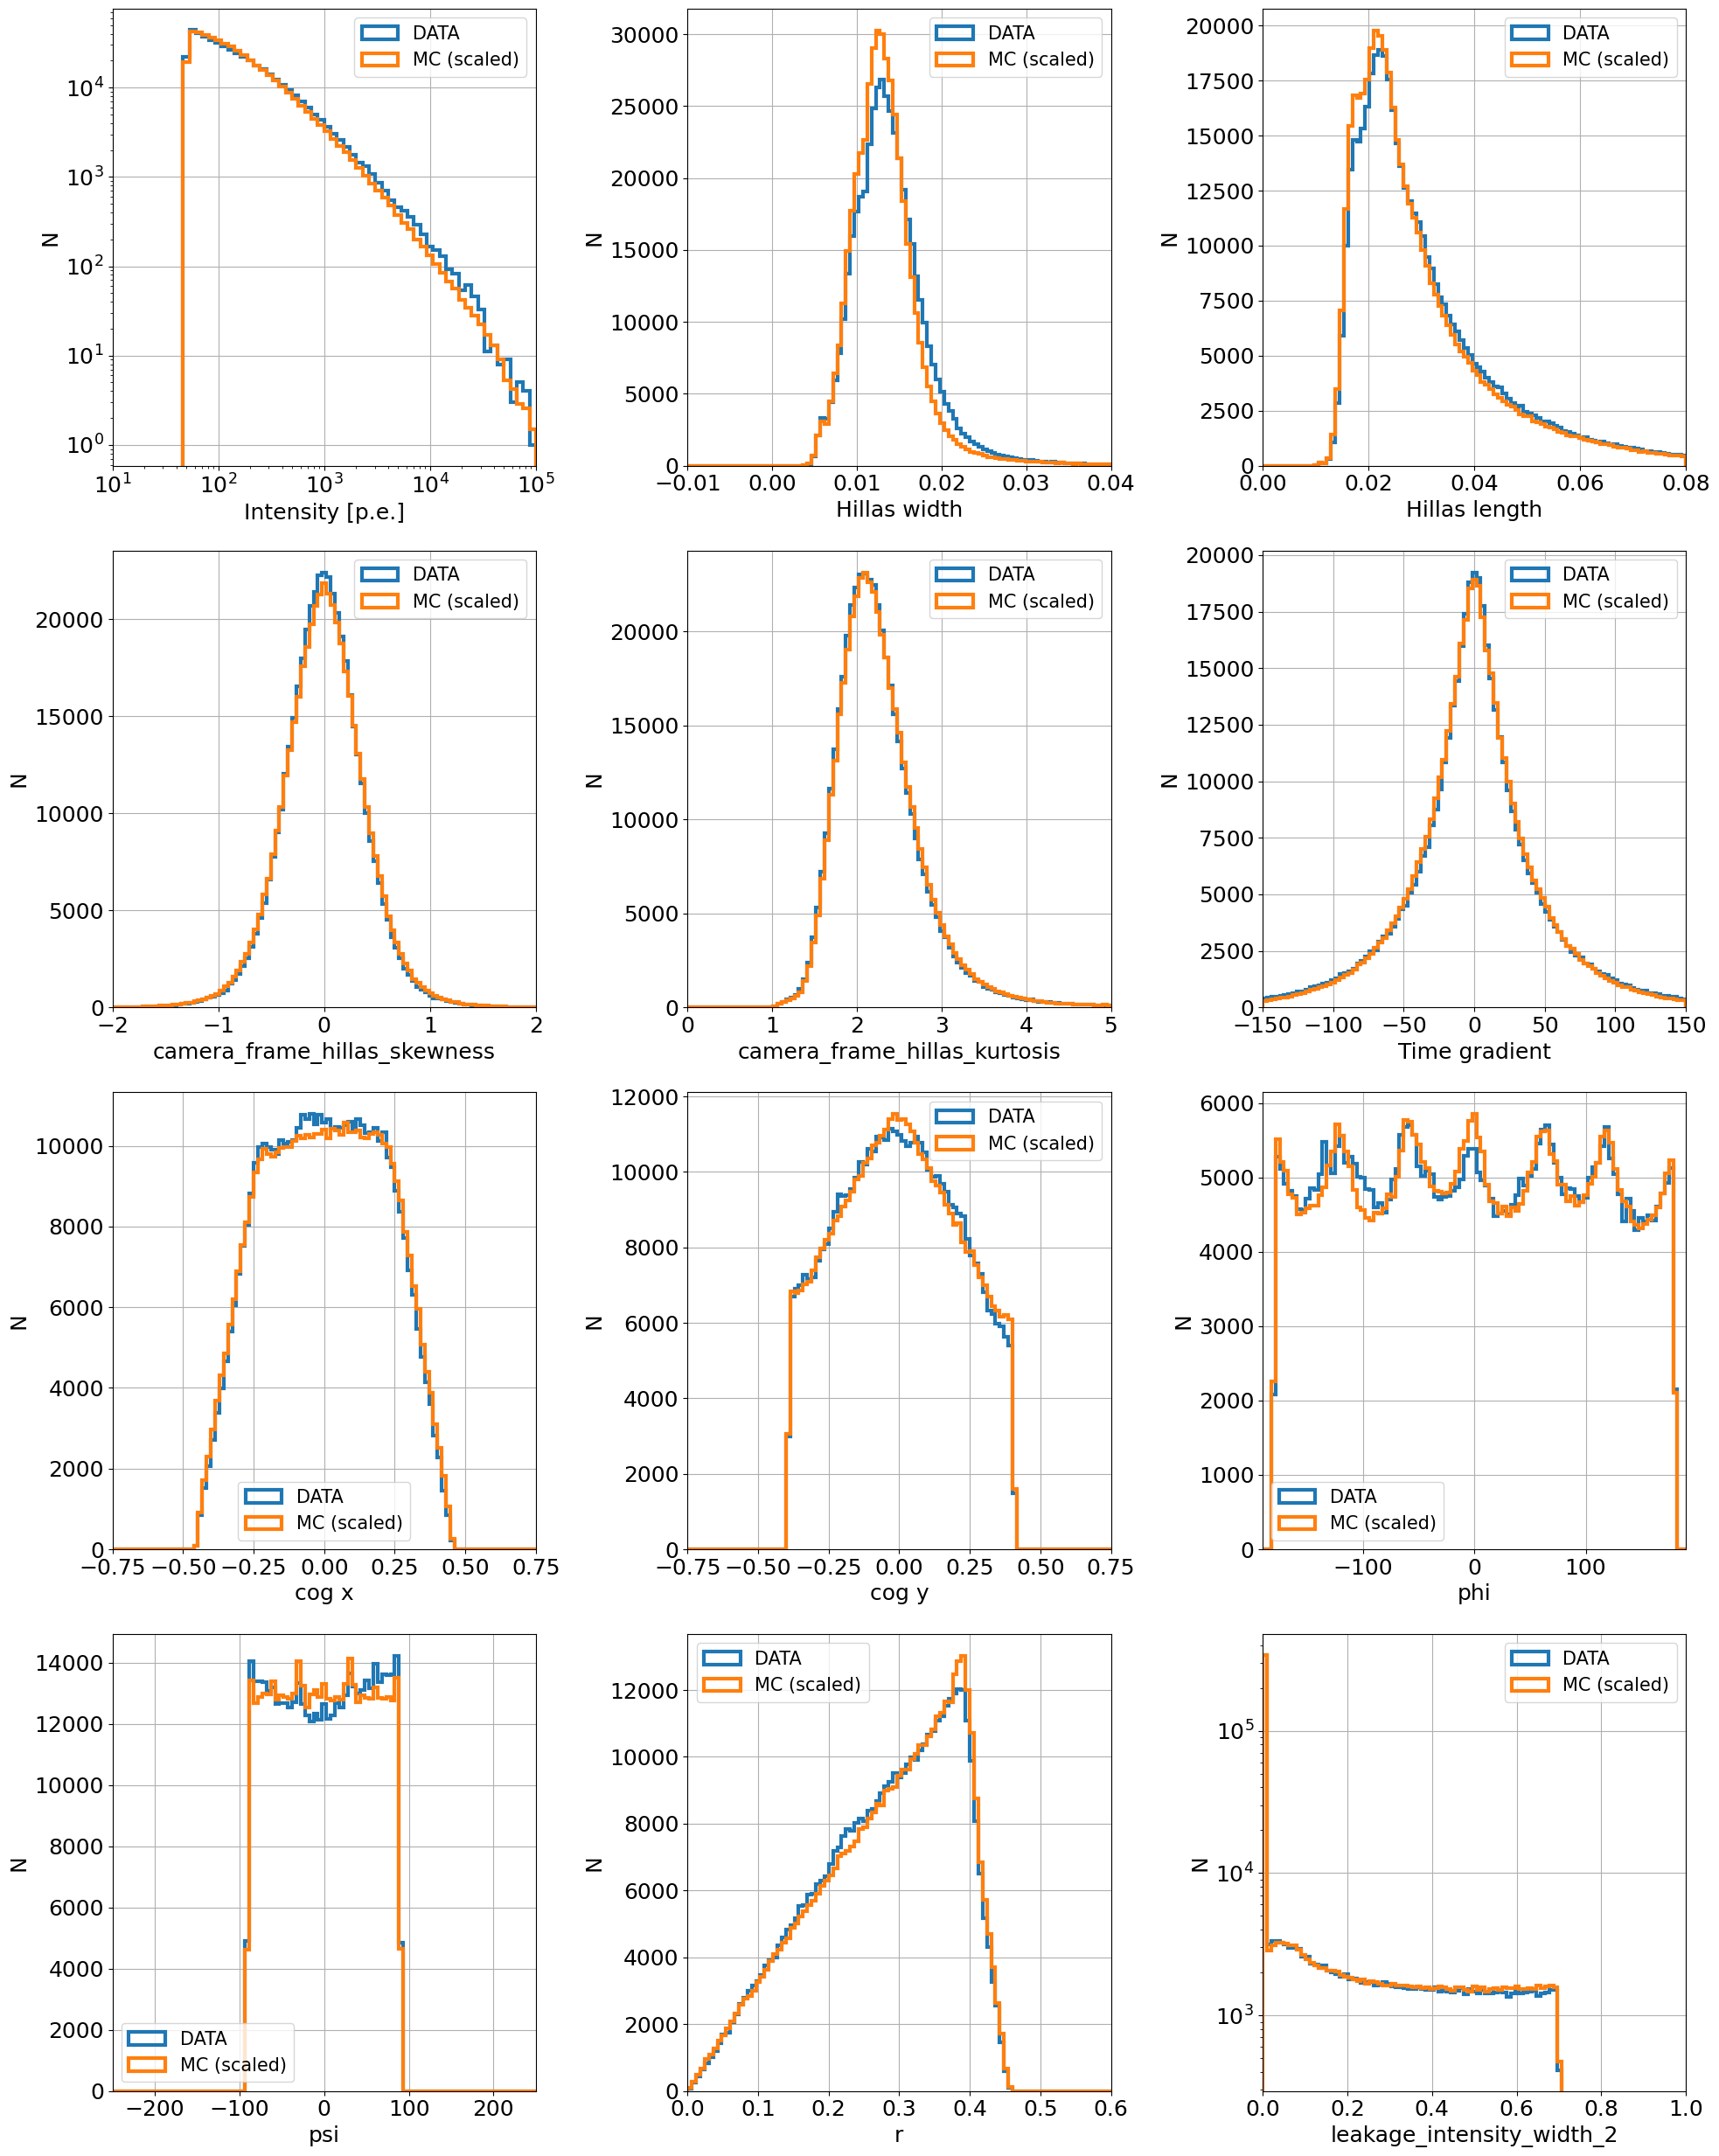

In [24]:
plot_mc_data(data=dl1_data[zenith_mask], mc=proton_diffuse, scale=scale/1.)

### COG event distribution

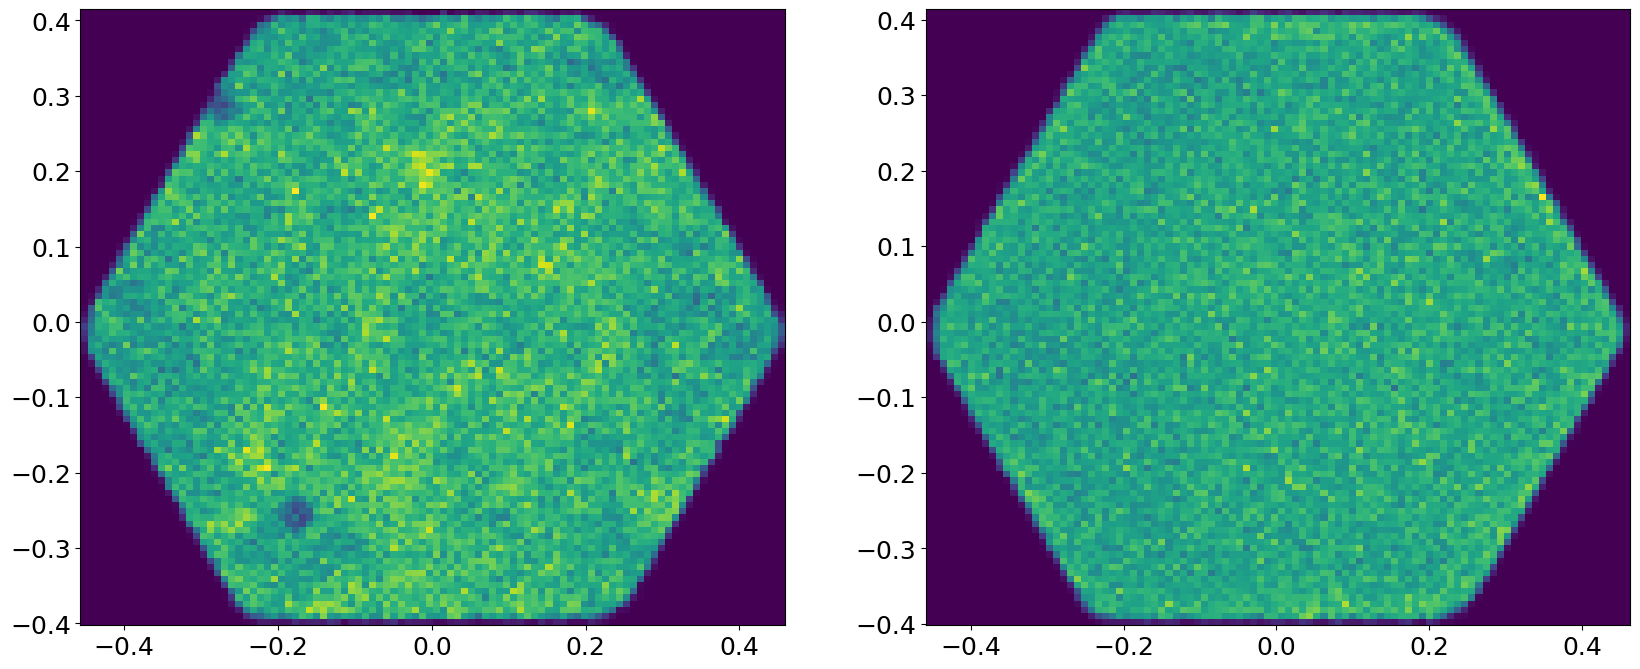

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
h = ax[0].hist2d(dl1_data[zenith_mask]['camera_frame_hillas_x'], dl1_data[zenith_mask]['camera_frame_hillas_y'], bins=100)
h = ax[1].hist2d(proton_diffuse['camera_frame_hillas_x'], proton_diffuse['camera_frame_hillas_y'], bins=100, weights=scale*proton_diffuse["weight"])

### One can also check where are the most problematic showers, e.g.:

In [26]:
mask = (dl1_data['morphology_n_islands'] > 1)
mask_mc = (proton_diffuse['morphology_n_islands'] > 1)

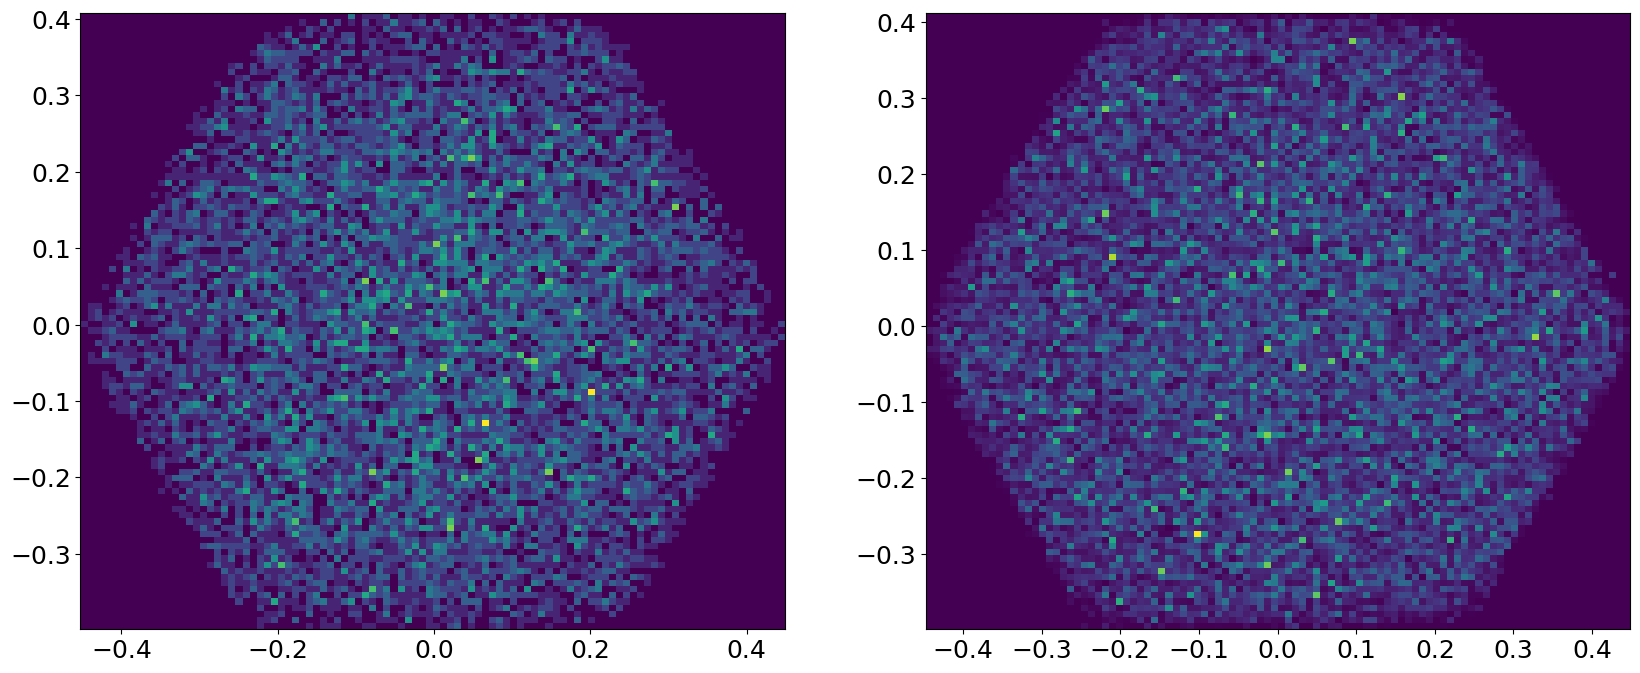

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
h = ax[0].hist2d(dl1_data[zenith_mask & mask]['camera_frame_hillas_x'], dl1_data[zenith_mask & mask]['camera_frame_hillas_y'], bins=100)
h = ax[1].hist2d(proton_diffuse[mask_mc]['camera_frame_hillas_x'], proton_diffuse[mask_mc]['camera_frame_hillas_y'], bins=100, weights=scale*proton_diffuse[mask_mc]["weight"])